# ADA - Homework 2

### Requests
For easily sending HTTP requests, we use [Requests](http://docs.python-requests.org/en/master/)

In [1]:
import requests

### BeautifulSoup
For parsing HTML content, we use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/)

In [2]:
from bs4 import BeautifulSoup

### Pandas and Numpy
For data manipulation

In [3]:
import pandas as pd
import numpy as np

### Seaborn
For plots and graphs

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')

### Scipy
For statistical significance tests

In [5]:
from scipy.stats import ttest_ind

## Requesting and parsing data from IS-Academia

We parse the first page to get all the option fields useful to make queries later 

In [6]:
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?&ww_i_reportmodel=133685247')
soup = BeautifulSoup(r.text, 'html.parser')
options = {}

for option in soup.find_all('option'):
    options[option.parent.get('name')]=options.get(option.parent.get('name'),{})
    options[option.parent.get('name')][option.text]=option.get('value')

print(options)

{'ww_x_HIVERETE': {'': 'null',
  "Semestre d'automne": '2936286',
  'Semestre de printemps': '2936295'},
 'ww_x_PERIODE_ACAD': {'': 'null',
  '2007-2008': '978181',
  '2008-2009': '978187',
  '2009-2010': '978195',
  '2010-2011': '39486325',
  '2011-2012': '123455150',
  '2012-2013': '123456101',
  '2013-2014': '213637754',
  '2014-2015': '213637922',
  '2015-2016': '213638028',
  '2016-2017': '355925344'},
 'ww_x_PERIODE_PEDAGO': {'': 'null',
  'Bachelor semestre 1': '249108',
  'Bachelor semestre 2': '249114',
  'Bachelor semestre 3': '942155',
  'Bachelor semestre 4': '942163',
  'Bachelor semestre 5': '942120',
  'Bachelor semestre 5b': '2226768',
  'Bachelor semestre 6': '942175',
  'Bachelor semestre 6b': '2226785',
  'Master semestre 1': '2230106',
  'Master semestre 2': '942192',
  'Master semestre 3': '2230128',
  'Master semestre 4': '2230140',
  'Mineur semestre 1': '2335667',
  'Mineur semestre 2': '2335676',
  'Mise à niveau': '2063602308',
  'Projet Master automne': '2491

We define the function `get_data` using the previous object to build queries to the ISA form.

In [7]:
def get_data(unite_acad,periode_acad,periode_pedago,hiverete):
    """ Get data with specific parameters.
    
        Args:
            unite_acad (str): categorical from options.ww_x_UNITE_ACAD.keys()
            periode_acad (str): categorical from options.ww_x_PERIODE_ACAD.keys()
            periode_pedago (str): categorical from options.ww_x_PERIODE_PEDAGO.keys()
            hiverete (str): categorical from options.ww_x_HIVERETE.keys()
            
        Returns:
            DataFrame: Pandas dataframe containing the requested data.
            
    """
    request = ('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?'
        + 'ww_x_GPS=-1'
        + '&ww_i_reportModel=133685247'
        + '&ww_i_reportModelXsl=133685270'
        + '&ww_x_UNITE_ACAD=' + options['ww_x_UNITE_ACAD'][unite_acad]
        + '&ww_x_PERIODE_ACAD=' + options['ww_x_PERIODE_ACAD'][periode_acad]
        + '&ww_x_PERIODE_PEDAGO=' + options['ww_x_PERIODE_PEDAGO'][periode_pedago]
        + '&ww_x_HIVERETE='+ options['ww_x_HIVERETE'][hiverete]
    )
    soup = BeautifulSoup(requests.get(request).text, 'html.parser')
    
    table_lines = soup.find_all('tr')
    columns = [th.text for th in table_lines[1].contents] if len(table_lines)>1 else []
    nColumns = len(columns)
    
    data = {}
    for name in columns:
        data[name] = []
    
    for tr in table_lines[2:]:
        content = tr.contents
        if content[0].name=='td' :
            for i in range(nColumns):
                data[columns[i]].append(content[i].text)
    
    result = pd.DataFrame(data=data)
    result['ww_x_UNITE_ACAD']=unite_acad
    result['ww_x_PERIODE_ACAD']=periode_acad
    result['ww_x_PERIODE_PEDAGO']=periode_pedago
    result['ww_x_HIVERETE']=hiverete
    
    return result

A small test for the `get_data` method

In [8]:
get_data(
    'Informatique',
    '2007-2008',
    'Bachelor semestre 1',
    "Semestre d'automne"
).head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,ww_x_UNITE_ACAD,ww_x_PERIODE_ACAD,ww_x_PERIODE_PEDAGO,ww_x_HIVERETE
0,Monsieur,,,,169569,Arévalo Christian,,,,Présent,,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
1,Monsieur,,,,174905,Aubelle Flavien,,,,Présent,,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
2,Monsieur,,,,173922,Badoud Morgan,,,,Présent,,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
3,Monsieur,,,,179406,Baeriswyl Jonathan,,,,Présent,,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne
4,Monsieur,,,,179428,Barroco Michael,,,,Présent,,Informatique,2007-2008,Bachelor semestre 1,Semestre d'automne


We define a function `get_all_data`, taking lists of arguments to feed to the previous `get_data` function and returning the concatenated dataframe.

In [9]:
def get_all_data(unite_acads,periode_acads,periode_pedagos,hiveretes):
    """ Get data with specific parameters.
    
        Args:
            unite_acads ([str]): array of categoricals from options.ww_x_UNITE_ACAD.keys()
            periode_acads ([str]): array of categoricals from options.ww_x_PERIODE_ACAD.keys()
            periode_pedagos ([str]): array of categoricals from options.ww_x_PERIODE_PEDAGO.keys()
            hiveretes ([str]): array of categoricals from options.ww_x_HIVERETE.keys()
            
        Returns:
            DataFrame: Pandas dataframe containing the requested data.
            
    """
    result = pd.DataFrame({})
    for unite_acad in unite_acads:
        for periode_acad in periode_acads:
            for periode_pedago in periode_pedagos:
                for hiverete in hiveretes:
                    result = pd.concat([result,get_data(unite_acad,periode_acad,periode_pedago,hiverete)])
    return result

## Question 1

### Importing the data
Uses the function `get_all_data`

In [10]:
df_bachelor = get_all_data(
    ['Informatique'],
    ['2007-2008','2008-2009','2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017'],
    ['Bachelor semestre 1','Bachelor semestre 2','Bachelor semestre 3','Bachelor semestre 4','Bachelor semestre 5','Bachelor semestre 6','Bachelor semestre 5b','Bachelor semestre 6b'],
    ["Semestre d'automne",'Semestre de printemps']
)

In [11]:
print(df_bachelor.shape)
df_bachelor.head()

(5808, 15)


,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,ww_x_HIVERETE,ww_x_PERIODE_ACAD,ww_x_PERIODE_PEDAGO,ww_x_UNITE_ACAD
0,Monsieur,,,,169569,Arévalo Christian,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
1,Monsieur,,,,174905,Aubelle Flavien,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
2,Monsieur,,,,173922,Badoud Morgan,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
3,Monsieur,,,,179406,Baeriswyl Jonathan,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
4,Monsieur,,,,179428,Barroco Michael,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique


### Exploring the data

We do not know what are Bachelor semestre 5b and 6b, so we wanted to have a look at it, but these fields are empty.

In [12]:
print(df_bachelor[df_bachelor.ww_x_PERIODE_PEDAGO == 'Bachelor semestre 6b'].shape)
print(df_bachelor[df_bachelor.ww_x_PERIODE_PEDAGO == 'Bachelor semestre 5b'].shape)

(0, 15)
(0, 15)


Counting the number of students

In [13]:
print(len(df_bachelor['No Sciper'].unique()))

1481


### Filtering the data
The goal is to keep only students with a Bachelor semestre 1 & 6. For this we first create a list of the student having a bachelor semestre 1 which we call `df_bachelor_semestre_1` and another one for the semestre 6, `df_bachelor_semestre_6`. Then we use the function `isin` to filter the dataset 

In [14]:
df_bachelor_semestre_1 = df_bachelor[df_bachelor.ww_x_PERIODE_PEDAGO=='Bachelor semestre 1']
df_bachelor_semestre_6 = df_bachelor[df_bachelor.ww_x_PERIODE_PEDAGO=='Bachelor semestre 6']

In [15]:
df_bachelor_filtered = df_bachelor[df_bachelor['No Sciper'].isin(df_bachelor_semestre_1['No Sciper'].tolist())]
df_bachelor_filtered = df_bachelor_filtered[df_bachelor_filtered['No Sciper'].isin(df_bachelor_semestre_6['No Sciper'].tolist())]

print(df_bachelor_filtered.shape)
df_bachelor_filtered.head()

(2812, 15)


,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,ww_x_HIVERETE,ww_x_PERIODE_ACAD,ww_x_PERIODE_PEDAGO,ww_x_UNITE_ACAD
0,Monsieur,,,,169569,Arévalo Christian,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
1,Monsieur,,,,174905,Aubelle Flavien,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
3,Monsieur,,,,179406,Baeriswyl Jonathan,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
4,Monsieur,,,,179428,Barroco Michael,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique
7,Monsieur,,,,179449,Bindschaedler Vincent,,,,Présent,,Semestre d'automne,2007-2008,Bachelor semestre 1,Informatique


Counting the students. We have less students than before because we removed the students that started before 2007-2008 and finished after 2016-2017

In [16]:
print(len(df_bachelor_filtered['No Sciper'].unique()))

397


### Compute average of number of months 
At first we use the `group` method on the fields `Civilité` and `No Sciper` to group our data entries by sex and individual students, then we aggregate with the function `size` to know the number of semesters that each student has gone through. We consider that the number of months of study of a student is 6 times his number of semesters. We also assume that students with more than 6 semesters have completed the bachelor.

*The question, "Compute how many months it took each student to go from the first to the sixth semester.", being quite unclear, we considered instead the time needed to complete the bachelor*

In [17]:
df_bachelor_grouped = df_bachelor_filtered[['Civilité','No Sciper','ww_x_PERIODE_PEDAGO']].groupby(['Civilité','No Sciper'])
print('number of F: %d' % (df_bachelor_grouped.size()['Madame'].count()))
print('number of M: %d' % (df_bachelor_grouped.size()['Monsieur'].count()))
print('F avg number of months: %f' % (df_bachelor_grouped.size()['Madame'].mean()*6))
print('M avg number of months: %f' % (df_bachelor_grouped.size()['Monsieur'].mean()*6))

number of F: 29
number of M: 368
F avg number of months: 40.758621
M avg number of months: 42.635870


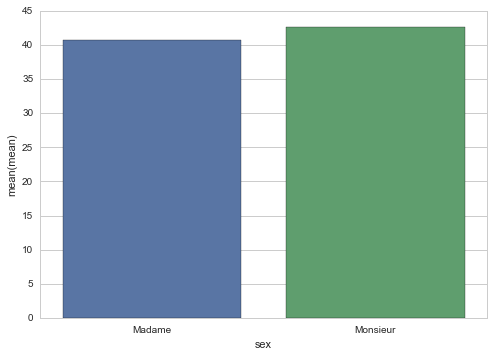

In [18]:
sns.barplot(x='sex', y='mean', data=pd.DataFrame({
    "sex": ["Madame","Monsieur"],
    "mean": [df_bachelor_grouped.size()['Madame'].mean()*6,df_bachelor_grouped.size()['Monsieur'].mean()*6]
}))

### Statistical significance
We compute the statistical difference between Female and Male average number of months. For that, we use a t-test: This is a two-sided test for the null hypothesis. It shows if two independent samples have identical average (expected) values. We see that the pvalue = 0.288 (> 0.05), meaning that we cannot reject the null hypothesis. We cannot say that the female students take longer or shorter to finish their bachelor in Computer Science than the male students.

In [19]:
f = [6*x for x in df_bachelor_grouped.size()['Madame'].tolist()]
m = [6*x for x in df_bachelor_grouped.size()['Monsieur'].tolist()]
ttest_ind(f, m)

Ttest_indResult(statistic=-1.0643000334248713, pvalue=0.28784297465161934)

## Question 2

### Importing the data
Uses the function `get_all_data`

In [20]:
df_master = get_all_data(
    ['Informatique'],
    ['2007-2008','2008-2009','2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017'],
    ['Master semestre 1','Master semestre 2','Master semestre 3','Master semestre 4','Mineur semestre 1','Mineur semestre 2','Projet Master automne','Projet Master printemps'],
    ["Semestre d'automne",'Semestre de printemps']
)

In [21]:
print(df_master.shape)
df_master.head()

(2844, 15)


,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,ww_x_HIVERETE,ww_x_PERIODE_ACAD,ww_x_PERIODE_PEDAGO,ww_x_UNITE_ACAD
0,Monsieur,,,,153066,Aeberhard François-Xavier,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
1,Madame,,,,180027,Agarwal Megha,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
2,Monsieur,,,,152232,Anagnostaras David,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
3,Monsieur,,,,177395,Auroux Damien,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
4,Monsieur,,,,161970,Awalebo Joseph,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique


### Exploring the data

About the field `Spécialisation`

In [22]:
df_master['Spécialisation'].unique()

array(['', 'Internet computing', 'Foundations of Software', 'Biocomputing',
       'Signals, Images and Interfaces', 'Computer Engineering - SP',
       'Service science', 'Software Systems', 'Information Security - SP',
       'Data Analytics', 'Internet Information Systems',
       'Computer Science Theory'], dtype=object)

In [23]:
df_master_specialisation = df_master[df_master.Spécialisation!=""]
print("Number of unique master students: %d" % df_master['No Sciper'].unique().size)
print("Number of unique master students who did a spécialisation: %d" % df_master_specialisation['No Sciper'].unique().size)

Number of unique master students: 977
Number of unique master students who did a spécialisation: 287


In [24]:
df_master_specialisation[['No Sciper','Spécialisation']].head()

,No Sciper,Spécialisation
13,180072,Internet computing
32,165819,Foundations of Software
42,172611,Biocomputing
50,179878,Internet computing
53,180160,Internet computing


About the field `ww_x_PERIODE_PEDAGO` and the options 'Mineur semestre 1' and 'Mineur semestre 2'

In [25]:
print(df_master[df_master.ww_x_PERIODE_PEDAGO == 'Mineur semestre 1'].shape)
print(df_master[df_master.ww_x_PERIODE_PEDAGO == 'Mineur semestre 2'].shape)

(0, 15)
(0, 15)


### Filtering the data

We decide to consider that a student completes the master by doing his/her Master Project.

In [26]:
df_master_pdm = df_master[df_master.ww_x_PERIODE_PEDAGO.isin(['Projet Master automne','Projet Master printemps'])]
df_master_semestre1 = df_master[df_master.ww_x_PERIODE_PEDAGO.isin(['Master semestre 1'])]

In [27]:
df_master_filtered = df_master[df_master['No Sciper'].isin(df_master_pdm['No Sciper'].tolist())]
df_master_filtered = df_master_filtered[df_master_filtered['No Sciper'].isin(df_master_semestre1['No Sciper'].tolist())]
df_master_filtered.head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,ww_x_HIVERETE,ww_x_PERIODE_ACAD,ww_x_PERIODE_PEDAGO,ww_x_UNITE_ACAD
1,Madame,,,,180027,Agarwal Megha,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
8,Madame,,,,154573,Benabdallah Zeineb,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
10,Monsieur,,,,172687,Billaud Joël,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
13,Monsieur,,,,180072,Campora Simone,,,Internet computing,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique
16,Monsieur,,,,160225,Cassata Alexandre,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique


### Compute average of number of months 

At first we use the `group` method on the field `No Sciper` to group our data entries by individual students, then we aggregate with the function `size` to know the number of semesters that each student has gone through. We consider that the number of months of study of a student is 6 times his number of semesters.

In [28]:
df_master_grouped = df_master_filtered[['No Sciper','ww_x_PERIODE_PEDAGO']].groupby(['No Sciper'])
print('number of students: %d' % (df_master_grouped.size().count()))
print('average number of months: %f' % (df_master_grouped.size().mean()*6))

number of students: 114
average number of months: 25.578947


### Specialisation 

In this section we want to explore the time differences depending on the choice of specializations. Is there a statistical difference between the average student master duration between different specializations? We show how to manipulate the data to compute the averages, however we do not have enough data to conclude on the significance of our results.

In [29]:
specialisations = df_master['Spécialisation'].unique()[1:]
def get_spe(sciper):
    for specialisation in specialisations:
        if sciper in df_master[df_master.Spécialisation==specialisation]['No Sciper'].tolist():
            return specialisation
    return ''

df_master_filtered['SpeName'] = df_master_filtered['No Sciper'].apply(get_spe)
df_master_filtered.head()

,Civilité,Ecole Echange,Filière opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,ww_x_HIVERETE,ww_x_PERIODE_ACAD,ww_x_PERIODE_PEDAGO,ww_x_UNITE_ACAD,SpeName
1,Madame,,,,180027,Agarwal Megha,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique,
8,Madame,,,,154573,Benabdallah Zeineb,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique,Biocomputing
10,Monsieur,,,,172687,Billaud Joël,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique,
13,Monsieur,,,,180072,Campora Simone,,,Internet computing,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique,Internet computing
16,Monsieur,,,,160225,Cassata Alexandre,,,,Présent,,Semestre d'automne,2007-2008,Master semestre 1,Informatique,


In [30]:
df_master_grouped_with_spe = df_master_filtered[['No Sciper','ww_x_PERIODE_PEDAGO','SpeName']].groupby(['SpeName','No Sciper'])

For specialization : Internet computing
number of students: 11
average number of months: 28.363636

For specialization : Foundations of Software
number of students: 7
average number of months: 30.857143

For specialization : Signals, Images and Interfaces
number of students: 2
average number of months: 33.000000

For specialization : Biocomputing
number of students: 1
average number of months: 36.000000

For specialization : Service science
number of students: 1
average number of months: 30.000000

For specialization : Information Security - SP
number of students: 2
average number of months: 30.000000

For specialization : Software Systems
number of students: 2
average number of months: 30.000000

For specialization : Computer Engineering - SP
number of students: 2
average number of months: 30.000000




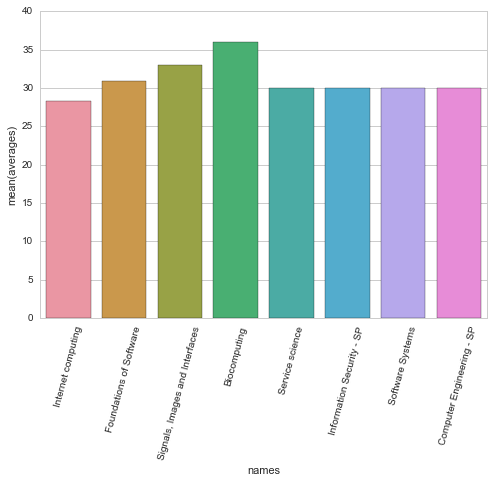

In [31]:
data = {
    'names':[],
    'averages':[]
}

for speName in df_master_filtered['Spécialisation'].unique()[1:]:
    data['names'].append(speName)
    data['averages'].append(df_master_grouped_with_spe.size()[speName].mean()*6)
    print('For specialization : %s' % speName)
    print('number of students: %d' % (df_master_grouped_with_spe.size()[speName].count()))
    print('average number of months: %f' % (df_master_grouped_with_spe.size()[speName].mean()*6))
    print()
    
sns.barplot(x='names', y='averages', data=pd.DataFrame(data))
plt.xticks(rotation=75)
print()

## Question 3 (BONUS)
Please read if you want to give us more points :-) 

### Computation of average master durations (in months)

We observe that female student have a lower average number of months, but the size of our data is not sufficient to prove the significance of our result.

In [32]:
df_master_grouped = df_master_filtered[['Civilité','No Sciper','ww_x_PERIODE_PEDAGO']].groupby(['Civilité','No Sciper'])
print('number of F: %d' % (df_master_grouped.size()['Madame'].count()))
print('number of M: %d' % (df_master_grouped.size()['Monsieur'].count()))
print('F avg number of months: %f' % (df_master_grouped.size()['Madame'].mean()*6))
print('M avg number of months: %f' % (df_master_grouped.size()['Monsieur'].mean()*6))

number of F: 13
number of M: 101
F avg number of months: 24.923077
M avg number of months: 25.663366


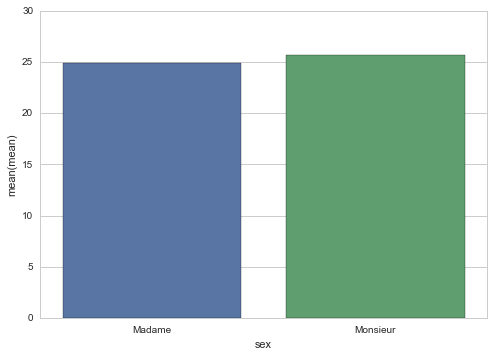

In [33]:
sns.barplot(x='sex', y='mean', data=pd.DataFrame({
    "sex": ["Madame","Monsieur"],
    "mean": [df_master_grouped.size()['Madame'].mean()*6,df_master_grouped.size()['Monsieur'].mean()*6]
}))

### Statistical significance

We compute the statistical difference between Female and Male average number of months. For that, we use a t-test: This is a two-sided test for the null hypothesis. It shows if two independent samples have identical average expected values. We see that the pvalue = 0.69 (> 0.05), meaning that we cannot reject the null hypothesis.

In [34]:
f = [6*x for x in df_master_grouped.size()['Madame'].tolist()]
m = [6*x for x in df_master_grouped.size()['Monsieur'].tolist()]
ttest_ind(f, m)

Ttest_indResult(statistic=-0.39806237735379579, pvalue=0.69134195843335544)